In [1]:
import os
os.chdir('..')
os.getcwd()

'/Users/sandrinechausson/Documents/easyclaimsdetection'

In [2]:
import json
import pandas as pd
from annotator import BissectionAnnotator

# Active Learning annotation using the Probabilistic Bisection Algorithm

In [3]:
train_df = pd.read_pickle('./data/training.pkl')

In [4]:
config_list = [
    {
        'NAME': 'BART',
        'COLUMN_NAME': 'FSL_BART',
        'START': 0,
        'END': 1,
        'P': 0.7,
    }, {
        'NAME': 'DistilBART',
        'COLUMN_NAME': 'FSL_DistilBART',
        'START': 0,
        'END': 1,
        'P': 0.7,
    }, {
        'NAME': 'DeBERTa',
        'COLUMN_NAME': 'FSL_DeBERTa',
        'START': 0,
        'END': 1,
        'P': 0.7,
    }, {
        'NAME': 'SBERT',
        'COLUMN_NAME': 'sbert_cosine',
        'START': -1,
        'END': 1,
        'P': 0.7,
    }, {
        'NAME': 'BART_top_2_avg',
        'COLUMN_NAME': 'FSL_BART',
        'START': 0,
        'END': 1,
        'P': 0.7,        
    }, {
        'NAME': 'BART_top_1_only',
        'COLUMN_NAME': 'FSL_BART',
        'START': 0,
        'END': 1,
        'P': 0.7,        
    }, {
        'NAME': 'BART_neg',
        'COLUMN_NAME': 'FSL_BART_pos_and_neg',
        'START': 0,
        'END': 1,
        'P': 0.7,       
    }, {
        'NAME': 'BART_0-6',
        'COLUMN_NAME': 'FSL_BART',
        'START': 0,
        'END': 1,
        'P': 0.6,
    }, {
        'NAME': 'BART_0-8',
        'COLUMN_NAME': 'FSL_BART',
        'START': 0,
        'END': 1,
        'P': 0.8,
    }, {
        'NAME': 'BART_0-9',
        'COLUMN_NAME': 'FSL_BART',
        'START': 0,
        'END': 1,
        'P': 0.9,        
    }, {
        'NAME': 'BART_extras',
        'COLUMN_NAME': 'FSL_BART_extras',
        'START': 0,
        'END': 1,
        'P': 0.7,
    }
]

In [5]:
for i, config in enumerate(config_list):
    print('\t*', i, ':\t', config['NAME'])

	* 0 :	 BART
	* 1 :	 DistilBART
	* 2 :	 DeBERTa
	* 3 :	 SBERT
	* 4 :	 BART_top_2_avg
	* 5 :	 BART_top_1_only
	* 6 :	 BART_neg
	* 7 :	 BART_0-6
	* 8 :	 BART_0-8
	* 9 :	 BART_0-9
	* 10 :	 BART_extras


In [6]:
config_index = 6
config = config_list[config_index]
print(config['NAME'])

BART_neg


## Load claims

In [13]:
with open('./data/claims/claims.json') as file:
    claims = json.load(file)
    
if config['NAME'] == 'BART_extras':       
    with open('./data/claims/claims_extras.json') as file:
        claims_extras = json.load(file)
    claims = {**claims, **claims_extras}
    
elif config['NAME'] == 'BART_neg':
     with open('./data/claims/claims_neg.json') as file:
        claims_neg = json.load(file)   

In [14]:
claims_descr = {
    "1_1": "Ice/permafrost/snow cover isn’t melting",
    "1_2": "We’re heading into an ice age/global cooling",
    "1_3": "Weather is cold/snowing",
    "1_4": "Climate hasn’t warmed/changed over the last (few) decade(s)",
    "1_6": "Sea level rise is exaggerated/not accelerating",
    "1_7": "Extreme weather isn’t increasing/has happened before/isn’t linked to climate change",
}

## Normalise entailment scores for BART_neg

In [15]:
def normalise_nli_scores(row):
    dict_pos = {k: row['FSL_BART'][claims[k]] for k in claims}
    dict_neg = {k: row['FSL_BART_neg'][claims_neg[k]] for k in claims_neg}
    new_dict = dict()
    for k in dict_pos:
        if dict_neg[k] > dict_pos[k]:
            new_dict[claims[k]] = 0.0
        else:
            new_dict[claims[k]] = dict_pos[k]
    return new_dict

In [18]:
if config['NAME'] == 'BART_neg':
    train_df[config['COLUMN_NAME']] = train_df.apply(normalise_nli_scores, axis=1)

## Annotate

In [19]:
annotator = BissectionAnnotator(train_df, config['START'], config['END'], step=0.01, p=config['P'], level='class', sleep_time=1)


ANNOT NB: 4
MEDIAN: 0.810

INTERVAL: 0.100 - 0.990 	==> WIDTH: 0.890
TOTAL = 1.0000000000000004
LEFT MASS = 0.488 	RIGHT MASS = 0.512 	TOTAL = 1.000



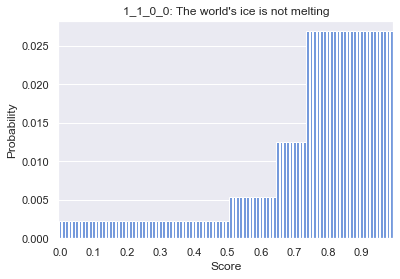


SCORE:	 0.804 (diff. = 0.006)

TEXT:

As you can see from the graph below global sea ice extent is nearly on average since 1979 according to satellite measurement.
Arctic sea ice is slightly below average and Antarctic sea ice is above average. The total sea ice extent shows no obvious
influence from global warming.

	CLAIM:	 The world's ice is not melting

TRUE


KeyboardInterrupt: 

In [20]:
for claim_idx in claims:
    if not claim_idx[:3] in claims_descr:
        continue
    claims_text = claims[claim_idx]
    df, threshold, prob_distr = annotator(claim_idx, claims_text, claim_idx[:3], claims_descr[claim_idx[:3]], column=config['COLUMN_NAME'])